In [1]:
import pymc3 as pm
import numpy as np
from scipy.stats import ttest_ind

In [13]:
np.random.seed(0)
conversions1 = np.random.binomial(1, 0.01, size=5400)
conversions2 = np.random.binomial(1, 0.012, size=4600)

In [14]:
# observed conversion rates
print(f'Conversion Rate 1: {conversions1.mean():.1%}')
print(f'Conversion Rate 2: {conversions2.mean():.1%}')

Conversion Rate 1: 0.9%
Conversion Rate 2: 1.1%


In [15]:
print(f'P-Value: {ttest_ind(conversions1, conversions2, equal_var=False, alternative="less").pvalue:.1%}')

P-Value: 11.5%


In [16]:
# Bayesian method
with pm.Model():
  # priors
  rate1 = pm.Beta('rate1', 1, 99)
  rate2 = pm.Beta('rate2', 1, 99)

  # model
  obs1 = pm.Bernoulli('obs1', rate1, observed=conversions1)
  obs2 = pm.Bernoulli('obs2', rate2, observed=conversions2)

  # sample
  trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rate2, rate1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


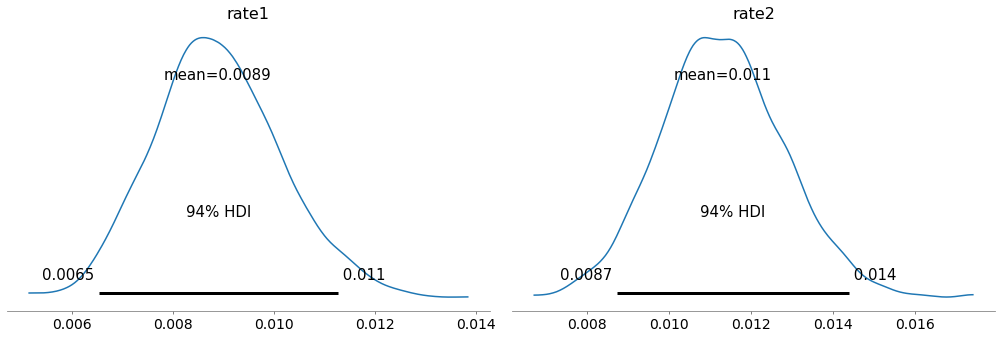

In [19]:
import arviz as az

az.plot_posterior(trace);

In [20]:
conversion1_samples = trace.posterior['rate1'].values
conversion2_samples = trace.posterior['rate2'].values

print(f'Probability that 2 is better than 1: {(conversion2_samples > conversion1_samples).mean():.1%}')

Probability that 2 is better than 1: 88.1%


# Real data time

In [21]:
import pandas as pd

In [26]:
data = pd.read_csv('Training_set_advance.csv')

In [32]:
# pretend everything else is randomized enough. We only want to test survival of urban vs. rural patients
use_data = data[['Patient_Rural_Urban', 'Survived_1_year']].copy()
use_data['urban'] = 0
use_data.loc[use_data['Patient_Rural_Urban']=='URBAN', 'urban'] = 1
use_data.head()

,Patient_Rural_Urban,Survived_1_year,urban
0,URBAN,1,1
1,RURAL,0,0
2,RURAL,1,0
3,RURAL,0,0
4,RURAL,1,0


In [34]:
urban = use_data.loc[use_data['urban'] == 1, 'Survived_1_year'].values
rural = use_data.loc[use_data['urban'] == 0, 'Survived_1_year'].values

In [36]:
# mean values
print(f'Urban Survival Rate: {np.mean(urban):.1%}')
print(f'Rural Survival Rate: {np.mean(rural):.1%}')

Urban Survival Rate: 54.7%
Rural Survival Rate: 67.2%


In [40]:
# traditional method
print(f'P-Value: {ttest_ind(urban, rural, equal_var=False).pvalue:.5%}')

P-Value: 0.00000%


In [41]:
# Bayesian method
with pm.Model():
  # prior
  urban_rate = pm.Beta('urban_rate', 5, 5)
  rural_rate = pm.Beta('rural_rate', 5, 5)

  # model
  urban_obs = pm.Bernoulli('urban_obs', urban_rate, observed=urban)
  rural_obs = pm.Bernoulli('rural_obs', rural_rate, observed=rural)

  # sample
  trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rural_rate, urban_rate]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


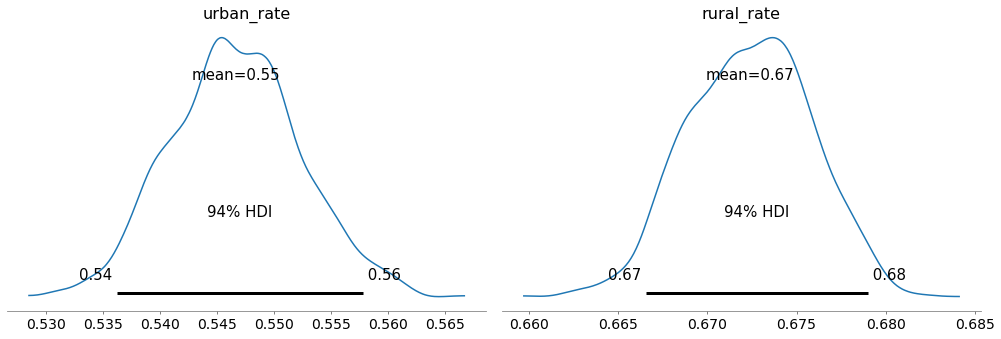

In [42]:
az.plot_posterior(trace);

In [45]:
urban_samples = trace.posterior['urban_rate'].values
rural_samples = trace.posterior['rural_rate'].values

print(f'Probability that Rural Patients survive at a higher rate than Urban Patients: {(rural_samples > urban_samples).mean():.5%}')

Probability that Rural Patients survive at a higher rate than Urban Patients: 100.00000%
